In [1]:
!pip install simpy


In [2]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR


In [3]:
def hospital_simulation(arrival_rate, service_rate, num_doctors, sim_time=300):
    env = simpy.Environment()
    doctors = simpy.Resource(env, capacity=num_doctors)

    waiting_times = []

    def patient(env, doctors):
        arrival_time = env.now
        with doctors.request() as request:
            yield request
            wait_time = env.now - arrival_time
            waiting_times.append(wait_time)
            service_time = random.expovariate(service_rate)
            yield env.timeout(service_time)

    def patient_generator(env):
        while True:
            yield env.timeout(random.expovariate(arrival_rate))
            env.process(patient(env, doctors))

    env.process(patient_generator(env))
    env.run(until=sim_time)

    if len(waiting_times) == 0:
        return 0
    return np.mean(waiting_times)


In [4]:
PARAM_BOUNDS = {
    "arrival_rate": (1, 10),     # patients per minute
    "service_rate": (2, 15),     # service speed
    "num_doctors": (1, 5),       # doctors
}


In [5]:
data = []

for i in range(1000):
    arrival_rate = random.uniform(*PARAM_BOUNDS["arrival_rate"])
    service_rate = random.uniform(*PARAM_BOUNDS["service_rate"])
    num_doctors = random.randint(*PARAM_BOUNDS["num_doctors"])

    avg_wait_time = hospital_simulation(
        arrival_rate,
        service_rate,
        num_doctors
    )

    data.append([
        arrival_rate,
        service_rate,
        num_doctors,
        avg_wait_time
    ])

df = pd.DataFrame(data, columns=[
    "arrival_rate",
    "service_rate",
    "num_doctors",
    "avg_wait_time"
])

df.head()


,arrival_rate,service_rate,num_doctors,avg_wait_time
0,9.549423,11.276387,3,0.002316
1,3.391049,4.399643,5,0.000000
2,3.706290,2.819896,2,0.195890
3,2.932417,10.255116,1,0.031491
4,8.806131,7.433314,1,13.653985


In [6]:
data = []

for i in range(1000):
    arrival_rate = random.uniform(*PARAM_BOUNDS["arrival_rate"])
    service_rate = random.uniform(*PARAM_BOUNDS["service_rate"])
    num_doctors = random.randint(*PARAM_BOUNDS["num_doctors"])

    avg_wait_time = hospital_simulation(
        arrival_rate,
        service_rate,
        num_doctors
    )

    data.append([
        arrival_rate,
        service_rate,
        num_doctors,
        avg_wait_time
    ])

df = pd.DataFrame(data, columns=[
    "arrival_rate",
    "service_rate",
    "num_doctors",
    "avg_wait_time"
])

df.head()


,arrival_rate,service_rate,num_doctors,avg_wait_time
0,7.595698,2.450924,2,50.352165
1,5.782384,13.742967,4,0.000028
2,1.100620,3.113306,2,0.014693
3,3.924560,7.808694,2,0.008961
4,5.950133,9.008017,5,0.000011


In [7]:
df.to_csv("synthetic_hospital_data.csv", index=False)
print("Dataset saved successfully!")


Dataset saved successfully!


In [8]:
X = df[["arrival_rate", "service_rate", "num_doctors"]]
y = df["avg_wait_time"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [9]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "KNN": KNeighborsRegressor(),
    "SVR": SVR()
}


In [10]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)

    results.append([name, mae, rmse, r2])

results_df = pd.DataFrame(
    results,
    columns=["Model", "MAE", "RMSE", "R2 Score"]
)

results_df


,Model,MAE,RMSE,R2 Score
0,Linear Regression,9.382914,17.348475,0.259442
1,Decision Tree,1.787011,6.217236,0.904889
2,Random Forest,1.177180,3.784979,0.964750
3,KNN,1.667573,5.550962,0.924182
4,SVR,5.885527,20.059301,0.009925


In [11]:
best_model = results_df.sort_values("RMSE").iloc[0]
best_model


,2
Model,Random Forest
MAE,1.17718
RMSE,3.784979
R2 Score,0.96475


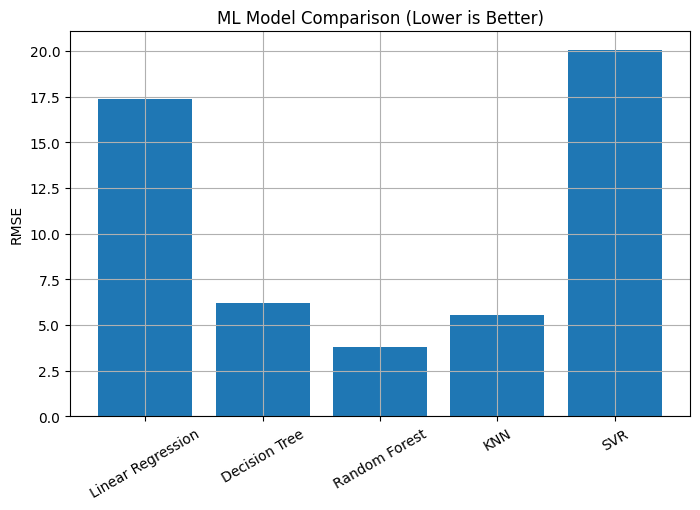

In [12]:
plt.figure(figsize=(8,5))
plt.bar(results_df["Model"], results_df["RMSE"])
plt.ylabel("RMSE")
plt.title("ML Model Comparison (Lower is Better)")
plt.xticks(rotation=30)
plt.grid(True)
plt.show()


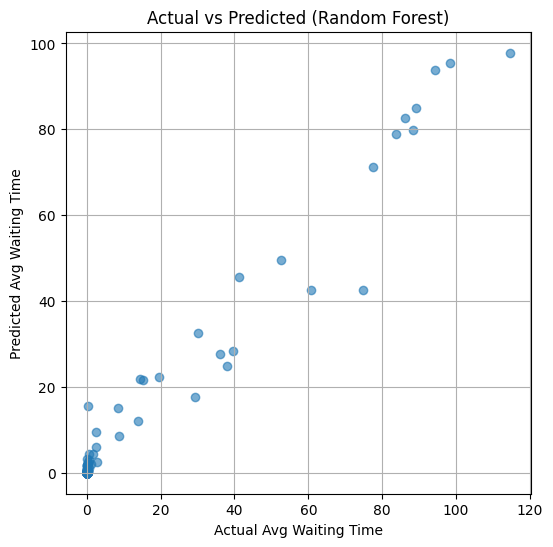

In [13]:
best_model_name = best_model["Model"]
model = models[best_model_name]

preds = model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, preds, alpha=0.6)
plt.xlabel("Actual Avg Waiting Time")
plt.ylabel("Predicted Avg Waiting Time")
plt.title(f"Actual vs Predicted ({best_model_name})")
plt.grid(True)
plt.show()


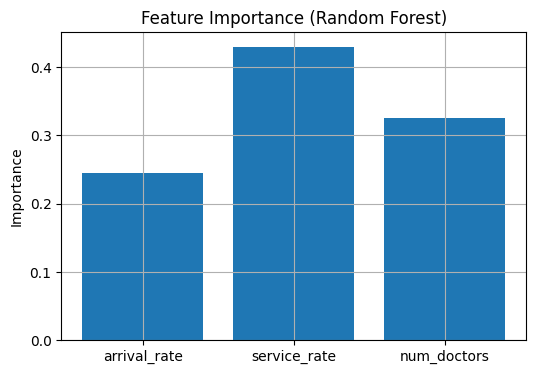

In [14]:
rf = models["Random Forest"]
importances = rf.feature_importances_

plt.figure(figsize=(6,4))
plt.bar(X.columns, importances)
plt.ylabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.grid(True)
plt.show()
